In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, root_mean_squared_error

df = pd.read_csv("uber.csv")

# Keep required numeric columns only
df = df[['fare_amount','passenger_count','pickup_latitude','pickup_longitude',
         'dropoff_latitude','dropoff_longitude']].dropna()

# Remove invalid values
df = df[(df['fare_amount'] > 0) & (df['passenger_count'] > 0)]
print(df.head())


   fare_amount  passenger_count  pickup_latitude  pickup_longitude  \
0          7.5                1        40.738354        -73.999817   
1          7.7                1        40.728225        -73.994355   
2         12.9                1        40.740770        -74.005043   
3          5.3                3        40.790844        -73.976124   
4         16.0                5        40.744085        -73.925023   

   dropoff_latitude  dropoff_longitude  
0         40.723217         -73.999512  
1         40.750325         -73.994710  
2         40.772647         -73.962565  
3         40.803349         -73.965316  
4         40.761247         -73.973082  



Dataset Shape: (198805, 7)

Missing Values:
fare_amount          0
passenger_count      0
pickup_latitude      0
pickup_longitude     0
dropoff_latitude     0
dropoff_longitude    0
distance_km          0
dtype: int64

Statistical Summary (numerical columns):


,fare_amount,passenger_count,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,distance_km
count,198805.000000,198805.000000,198805.000000,198805.000000,198805.000000,198805.000000,198805.000000
mean,11.361007,1.690556,39.959269,-72.581948,39.957756,-72.581007,3.268035
std,9.890178,1.384937,6.059461,10.174339,6.005269,10.174239,3.719992
min,0.010000,1.000000,-74.015515,-75.387785,-74.015750,-75.417737,0.000000
25%,6.000000,1.000000,40.734879,-73.992074,40.733910,-73.991418,1.213488
50%,8.500000,1.000000,40.752622,-73.981843,40.753071,-73.980118,2.116518
75%,12.500000,2.000000,40.767172,-73.967242,40.768017,-73.963760,3.857073
max,499.000000,208.000000,401.066667,40.808425,45.031598,40.831932,99.162509


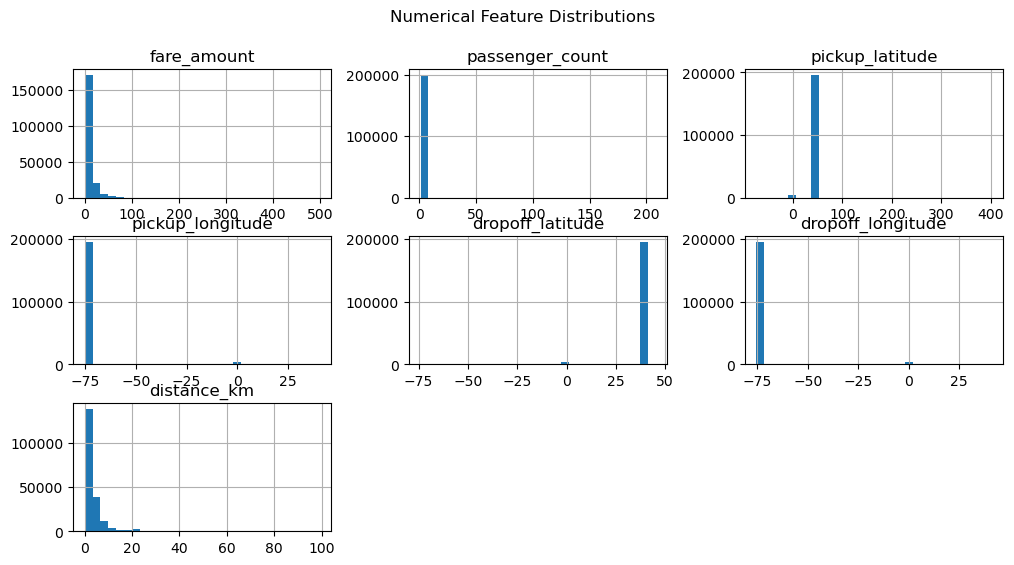

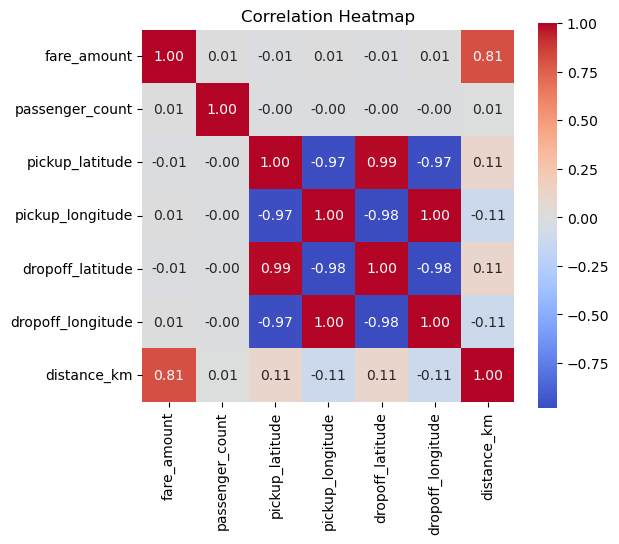

In [10]:
# 📊 Cell: Basic EDA (to run BEFORE distance feature creation)

print("\nDataset Shape:", df.shape)

print("\nMissing Values:")
print(df.isna().sum())

print("\nStatistical Summary (numerical columns):")
display(df.describe())

# Detect numeric columns automatically
num_cols = df.select_dtypes(include=['int64','float64']).columns.tolist()

# Show first few histograms (skip if too many features)
df[num_cols].hist(bins=30, figsize=(12,6))
plt.suptitle("Numerical Feature Distributions")
plt.show()

import seaborn as sns

# Compute correlation matrix
corr = df[num_cols].corr()

plt.figure(figsize=(6,5))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Heatmap")
plt.show()


In [40]:
def haversine(lat1, lon1, lat2, lon2):
    R = 6371
    lat1,lon1,lat2,lon2 = map(np.radians,[lat1,lon1,lat2,lon2])
    dlat = lat2-lat1
    dlon = lon2-lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    return R * (2*np.arcsin(np.sqrt(a)))

df['distance_km'] = haversine(df['pickup_latitude'],df['pickup_longitude'],
                              df['dropoff_latitude'],df['dropoff_longitude'])

df = df[df['distance_km'] < 100]   # remove outliers

X = df[['distance_km', 'passenger_count',
        'pickup_latitude', 'pickup_longitude',
        'dropoff_latitude', 'dropoff_longitude']].values

y = df[['fare_amount']].values



In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)


In [51]:
model_no_pca = LinearRegression()
model_no_pca.fit(X_train, y_train)
pred_no = model_no_pca.predict(X_test)

r2_no = r2_score(y_test, pred_no)
rmse_no = root_mean_squared_error(y_test, pred_no)
mae_no = mean_absolute_error(y_test, pred_no)

print("NO PCA --> R²:", r2_no, " RMSE:", rmse_no, " MAE:", mae_no)


NO PCA --> R²: 0.6865823502197491  RMSE: 5.626177588773975  MAE: 2.5934375395162856


In [58]:
# Standardize
mean = X_train.mean(axis=0)
std = X_train.std(axis=0)

X_train_std = (X_train - mean) / std
X_test_std  = (X_test - mean) / std 

cov = np.cov(X_train_std, rowvar=False)
eigvals, eigvecs = np.linalg.eigh(cov)

idx = np.argsort(eigvals)[::-1]
eigvals = eigvals[idx]
eigvecs = eigvecs[:, idx]

variance_ratio = eigvals / np.sum(eigvals)
cumulative_variance = np.cumsum(variance_ratio)

k = np.searchsorted(cumulative_variance, 0.95) + 1
print(f"\nKeeping {k} PCA components covering {cumulative_variance[k-1]*100:.2f}% variance")

PC = eigvecs[:, :k]

X_train_pca = X_train_std @ PC
X_test_pca  = X_test_std @ PC



Keeping 3 PCA components covering 99.10% variance


In [59]:
model_pca = LinearRegression()
model_pca.fit(X_train_pca, y_train)
pred_pca = model_pca.predict(X_test_pca)

r2_p = r2_score(y_test, pred_pca)
rmse_p = mean_squared_error(y_test, pred_pca, squared=False)
mae_p = mean_absolute_error(y_test, pred_pca)

print("WITH PCA --> R²:", r2_p, " RMSE:", rmse_p, " MAE:", mae_p)


WITH PCA --> R²: 0.6822429443346559  RMSE: 5.664992157090092  MAE: 2.597628393122099


C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [60]:
print("\n--- Model Performance Comparison ---\n")
print(f"Without PCA: R²={r2_no:.3f}, RMSE={rmse_no:.3f}, MAE={mae_no:.3f}")
print(f"With PCA   : R²={r2_p:.3f}, RMSE={rmse_p:.3f}, MAE={mae_p:.3f}")



--- Model Performance Comparison ---

Without PCA: R²=0.687, RMSE=5.626, MAE=2.593
With PCA   : R²=0.682, RMSE=5.665, MAE=2.598
